In [1]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
#from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
from BathPlateModel import BathPlateModel
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from HtoOmega import HtoOmega
#model=Cylinder_Yaxis_1Layer(sigma=5e7)
model=BathPlateModel(holes=2,outerBox="sphere", boxx=0.2, div_thick=2)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 2    Thickness: 0.00635
boxx=  0.2  boxy=  0.28  boxz=  0.4
div_thick=  2
name: hole1   mass: 7.619999999999999e-06   center: (0.02, 3.21245e-20, 5.42769e-20)
name: hole2   mass: 7.619999999999999e-06   center: (-0.02, 3.21245e-20, 5.42769e-20)
name: to_side   mass: 1.3335000000000002e-05   center: (9.92493e-19, 0.0178571, -1.50111e-20)
name: from_side   mass: 1.3335000000000002e-05   center: (0, -0.0178571, 4.91339e-21)
name: air   mass: 0.00015824625000000016   center: (0, -1.6727e-19, -6.62394e-20)
name: reduced   mass: 0.03331016538829113   center: (-1.39794e-17, -1.50936e-17, 2.19369e-19)
conductive_region: to_side|from_side
Conductor boundary: conductorBND|interface|interface2
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'red

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:
import math
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=True
feorder=2
mu=4e-7*math.pi
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

In [3]:
#field=UNIF(0,1,0,0)
field=model.coil.field
#coil=UNIF(0,0,0.01,0)
Bv=Bfield(field)
Hv=Bv/mu
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega)     
fesTOmega=fesT*fesOmega
(T,omega),(W, psi) = fesTOmega.TnT() 
gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega =gfTOmega.components
a= BilinearForm(fesTOmega)
a +=Mu*grad(omega)*grad(psi)*dx(air_region)
a +=Mu*(T+grad(omega))*(W+grad(psi))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

f = LinearForm(fesTOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesTOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesTOmega.FreeDofs()] = fcut

# Add Neumann condition terms
f += (normal*Bv)*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
fRHS=f

enter iccg_solve
Dof= 1398    matrix size= 5904.0
shift parameter= 1.0
minimum residual= 3.5000182529799554e-16  at iteraions:  42
結果のノルム: 2.3593482145369393e-11
power=  350152.6001719478


In [4]:
from LoopField import *
from ngsolve import *
from ngsolve.webgui import Draw
loops=LoopFields(model)
g=len(loops)
for k in range(g):
    Draw(loops[k], mesh)

Surface face count=  2326
Surface edge count=  3489
Surface node count=  1161
genus=  2
edge DOF =  80
enter iccg_solve
Dof= 16489    matrix size= 96230.0
shift parameter= 1.0
minimum residual= 6.928093277071182e-16  at iteraions:  76
結果のノルム: 5.039991300541081e-12
power=  1271.0002360235733
enter iccg_solve
Dof= 2600    matrix size= 11586.0
shift parameter= 1.0
minimum residual= 7.292905909895356e-17  at iteraions:  31
結果のノルム: 6.397903402361687e-16
power=  0.007652361819407029
k= 0    norm2= 3.4477964593431363e-07
edge DOF =  11703
enter iccg_solve
Dof= 16488    matrix size= 96220.0
shift parameter= 1.0
minimum residual= 8.834846105338815e-16  at iteraions:  73
結果のノルム: 5.1940022536686385e-12
power=  907.0928697369967
enter iccg_solve
Dof= 2600    matrix size= 11586.0
shift parameter= 1.0
minimum residual= 2.850235932732602e-17  at iteraions:  31
結果のノルム: 2.4213045013796464e-16
power=  0.005666805532244796
k= 1   kd= 0    prod= -4.217897188313471e-07
k= 1    norm2= 3.0206432501681727e-09

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

fv= [<ngsolve.comp.LinearForm object at 0x0000022E64E8B0F0>, <ngsolve.comp.LinearForm object at 0x0000022E64E55EF0>]
fafv [[(1.379217616449119e-06-1.2726629728999657e-05j), (4.382046667821405e-09-7.336800655049363e-07j)], [(4.382046667821405e-09-7.336800655049363e-07j), (1.3731714880139614e-06-1.3090412307151264e-05j)]]
dim= 58858   nadd= 2
size of matrix=  3290747
shift parameter= 1.01
minimum residual= 2.3300025742019303e-15  at iteraions:  78


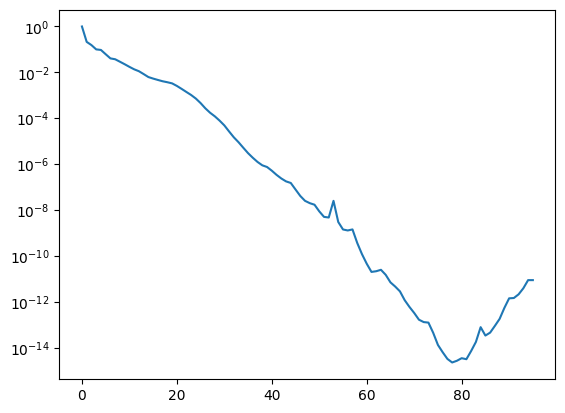

結果のノルム: 4.8106469314076635e-12


In [5]:
from LoopField import *
if g !=0 : 
    fv, fafv=loopFieldCouplings(loops, s, model, fesTOmega)
    print("fv=", fv)
    print("fafv", fafv)
    
    fg=[]
    for n in range(g): fg.append(0)
    sol, amp =solver.SolveCoupled2(fesTOmega, a, fv, fafv, fRHS.vec.FV(), fg,
                     tol=1.e-16, max_iter=200, accel_factor=0, logplot=True, complex=jomega)

    gfTOmega = GridFunction(fesTOmega)   #Clear gfTOmega
    gfT, gfOmega=gfTOmega.components
    #np.array(gfTOmega.vec.FV(), copy=False)[fesTOmega.FreeDofs()] +=sol
    for n in range(g):
        if n==0:
            loopsum= amp[0]*loops[0]
        else:
            loopsum +=amp[n]*loops[n]
    gfT.Set(loopsum, BND, mesh.Boundaries(conductor_boundary))
    np.array(gfTOmega.vec.FV(), copy=False)[fesTOmega.FreeDofs()] +=sol

    Tfield=gfT
    Tfield +=loopsum
else:
    gfTOmega = GridFunction(fesTOmega)   #Clear gfTOmega
    gfT, gfOmega=gfTOmega.components
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, fRHS.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, logplot=True, complex=jomega)   
    Tfield=gfT

fesOt=H1(mesh, order=feorder, definedon=total_region, complex=jomega)
fesOr=H1(mesh, order=feorder, definedon=reduced_region, complex=jomega)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))
#Oxr.Set(Ov, BND, mesh.Boundaries(total_boundary))

Bt=grad(Ot)*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu

Bfield=Mu*Tfield+Bt+Br+Bs
Jfield=curl(gfT)

In [6]:
from ngsolve import *
from ngsolve.webgui import Draw
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [7]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  0.2491427159967812


Apply Coil field, 　Dirichlet=False, feOrder=3

B field real [0, 0.00354]
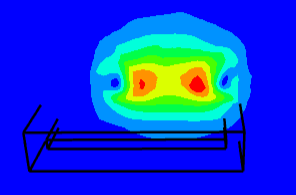

B field img [0, 0.00475]
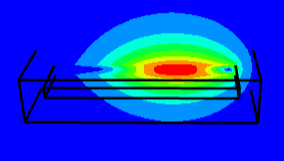

center magnetic field =  ((0.0046114017915582835-0.0002700835030015863j), (-2.871086876578396e-08+6.144269445770649e-08j), (0.005696655611467302-0.0035804087837488048j))

Apply Coil field, 　Dirichlet=False, feOrder=3

J field real [0, 5.97e5]
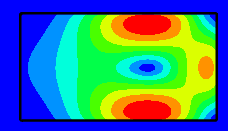

J field imag [0, 1.76e6]
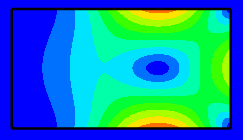

Average Joule loss=  0.34934970207307614  <-->0.3486242392846813 (A-Phi, feOrder=3)

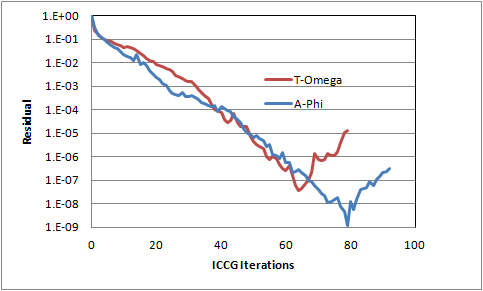